<a href="https://colab.research.google.com/github/TheDodoDev/PyTorch-Notes/blob/main/02_Neural_Network_Classification_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (can be multiple things as the options).

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=0.05,
                    random_state=42)

In [ ]:
print(f"X samples: \n{X[:5]}")
print(f"Y samples: \n{y[:5]}")

In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2":  X[:, 1],
                       "Y": y[:]})
circles.head(10)

In [ ]:
# Visualize the data
import matplotlib.pyplot as plt

plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: This is a toy dataset, a dataset that is small enough to experiment with but large enough to practice with.

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

### 1.2 Convert data from NumPy to tensors

In [ ]:
# Import torch
import torch
from torch import nn

In [ ]:
# Convert from NumPy
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test)

## 2. Build our model

1. Setup device agnostic code so our code will run on a GPU if there is one
2. Construct a model (by subclassing `nn.Module`)
  * Including the forward function
3. Define a loss function and optimizer
4. Build a training and test loop

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
X_train.device, X_test.device, y_train.device, y_test.device

In [ ]:
# Setting up our model
class CircleClassificationModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer1 = nn.Linear(in_features=2, out_features=8) # takes in 2 features and upscales to 8 features
    self.layer2 = nn.Linear(in_features=8, out_features=1) # takes the 8 features from last layer and downscales to 1 feature

  # Defining a forward method that outlines forward pass
  def forward(self, x):
    return self.layer2(self.layer1(x)) # x -> layer 1 -> layer2 -> output

# Instantiating an instance of our model class and send it to target device
model_0 = CircleClassificationModelV0().to(device)
model_0

In [ ]:
# nn.Sequential is useful for simple neural networks where each layer feeds into each other in order
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)
model_0

In [ ]:
model_0

In [ ]:
model_0.state_dict()

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)} | Shape: {untrained_preds.shape}")
print(f"Length of test sample : {len(X_test)} | Shape: {X_test.shape}")
print(f"First 10 samples: {untrained_preds[:10]}")

### 2.1 Setup loss function and optimizer

For classification problems, you would want to use Binary Cross Entropy or Cross Entropy depending on how many classifications you can make. For regression, you may use MAE or MSE. The most popular optimizers are SGD and Adam.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Combines BCE with a Sigmoid layer for numeric stability (requires Sigmoid function to activate neural network)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we need a training loop.
1. Forward pass
2. Loss function
3. Zero grad
4. Backpropagation
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [ ]:
# View first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.3526],
        [-0.2125],
        [-0.5430],
        [-0.2907],
        [-0.3095]], device='cuda:0')

In [ ]:
# Use the sigmoid activation function on our model logits to find prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4128],
        [0.4471],
        [0.3675],
        [0.4278],
        [0.4232]], device='cuda:0')

For our prediction probability values, we need to round them to either class 0 or 1 depending on our decision boundary.

In [ ]:
# Find prediction labels
y_preds = torch.round(y_pred_probs)

### 3.2 Build our training and testing loop

In [ ]:
epochs = 1000
torch.cuda.manual_seed(42)
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()

  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits.squeeze(), # Uses logits instead of prediction probabilities
                 y_train.squeeze())
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)
    if(epoch % 100 == 0 or epoch == epochs-1):
      print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc}| Test Loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.7096624374389648 | Accuracy: 50.0| Test Loss: 0.7125159502029419 | Test Accuracy: 50.0
Epoch: 100 | Loss: 0.6930084228515625 | Accuracy: 51.37500000000001| Test Loss: 0.6951248049736023 | Test Accuracy: 46.5
Epoch: 200 | Loss: 0.6929826736450195 | Accuracy: 51.625| Test Loss: 0.6947305798530579 | Test Accuracy: 46.0
Epoch: 300 | Loss: 0.6929817795753479 | Accuracy: 51.125| Test Loss: 0.6946735978126526 | Test Accuracy: 45.5
Epoch: 400 | Loss: 0.6929817199707031 | Accuracy: 51.37500000000001| Test Loss: 0.694665789604187 | Test Accuracy: 46.0
Epoch: 500 | Loss: 0.6929817199707031 | Accuracy: 51.625| Test Loss: 0.6946648955345154 | Test Accuracy: 45.5
Epoch: 600 | Loss: 0.6929817199707031 | Accuracy: 51.625| Test Loss: 0.6946648955345154 | Test Accuracy: 45.5
Epoch: 700 | Loss: 0.6929817199707031 | Accuracy: 51.625| Test Loss: 0.6946648955345154 | Test Accuracy: 45.5
Epoch: 800 | Loss: 0.6929816007614136 | Accuracy: 51.625| Test Loss: 0.6946648955345154 | Test Accuracy

## 4. Make predictions and evaluate the model

In [11]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Retrieving helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Retrieving helper_functions.py


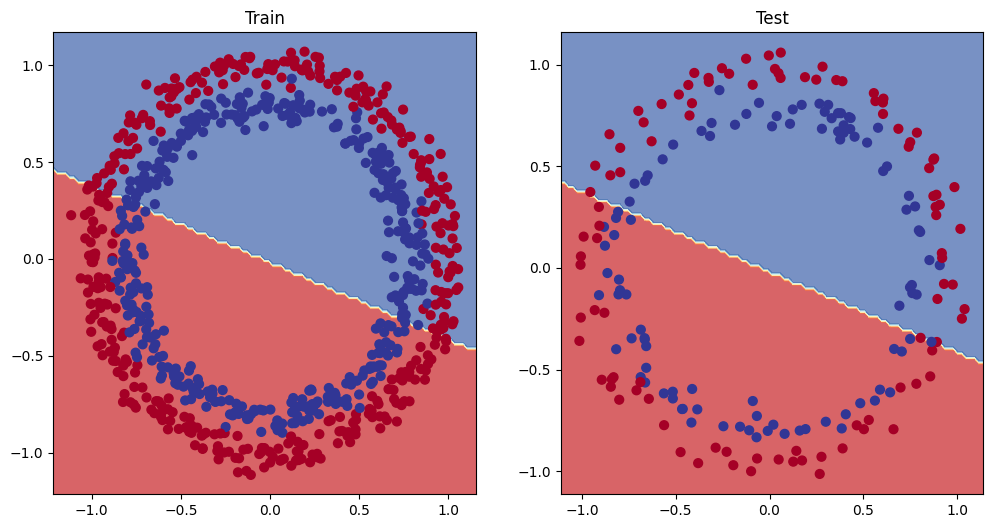

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers to give the model more chances to learn about patterns in the data
* Add more hidden units (increase the number of units in the hidden layer made using nn.Linear)
* Fit for longer (more epochs)
* Changing activation function
* Change the learning rate (can lead to exploding or vanishing gradient problems)
* Change the loss function or optimizer function

In [ ]:
class CircleClassificationModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=16)
    self.layer2 = nn.Linear(in_features=16, out_features=16)
    self.layer3 = nn.Linear(in_features=16, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)) )

model_1 = CircleClassificationModelV1()
model_1.to(device)

CircleClassificationModelV1(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Combines BCE with a Sigmoid layer for numeric stability (requires Sigmoid function to activate neural network)
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [ ]:
epochs = 10000
torch.cuda.manual_seed(42)
for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()

  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits.squeeze(), # Uses logits instead of prediction probabilities
                 y_train.squeeze())
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)
    if(epoch % 100 == 0 or epoch == epochs-1):
      print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc}| Test Loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.6943697929382324 | Accuracy: 53.37499999999999| Test Loss: 0.698628842830658 | Test Accuracy: 48.0
Epoch: 100 | Loss: 0.6936091184616089 | Accuracy: 51.74999999999999| Test Loss: 0.697224497795105 | Test Accuracy: 47.0
Epoch: 200 | Loss: 0.6933634877204895 | Accuracy: 51.24999999999999| Test Loss: 0.6965357661247253 | Test Accuracy: 47.5
Epoch: 300 | Loss: 0.6932381987571716 | Accuracy: 50.375| Test Loss: 0.6960833072662354 | Test Accuracy: 46.5
Epoch: 400 | Loss: 0.6931593418121338 | Accuracy: 50.24999999999999| Test Loss: 0.6957538723945618 | Test Accuracy: 48.0
Epoch: 500 | Loss: 0.6931062340736389 | Accuracy: 50.625| Test Loss: 0.6955054402351379 | Test Accuracy: 48.0
Epoch: 600 | Loss: 0.693069577217102 | Accuracy: 51.125| Test Loss: 0.6953152418136597 | Test Accuracy: 47.0
Epoch: 700 | Loss: 0.693044126033783 | Accuracy: 50.875| Test Loss: 0.6951686143875122 | Test Accuracy: 46.5
Epoch: 800 | Loss: 0.6930262446403503 | Accuracy: 51.37500000000001| Test Loss: 0.

KeyboardInterrupt: 

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
class CircleClassificationModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=8)
    self.layer2 = nn.Linear(in_features=8, out_features=8)
    self.layer3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.layer1(x))))



In [ ]:
model_2 = CircleClassificationModelV2().to(device)
print(model_2)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.001)


In [ ]:
torch.manual_seed(42)
epochs = 10000
model_2.to(device)
for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_train)
  y_preds = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits.squeeze(), y_train)
  acc = accuracy_fn(y_train, y_preds.squeeze())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "CircleClassficationModelV2.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
loaded_model = CircleClassificationModelV2()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(loaded_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(loaded_model, X_test, y_test)

## Multiclass Model Application

### Creating a toy dataset

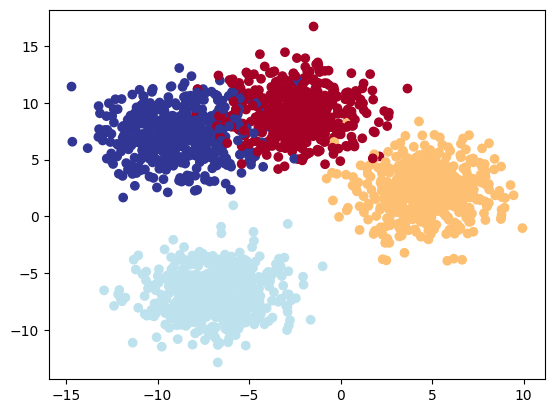

In [1]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_SAMPLES = 2000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=2,
                            random_state=RANDOM_SEED)
# Visualize our data
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)
# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Assigning data set to device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

### Creating our model

In [4]:
class BlobClassificationModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_features=16):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(input_features, hidden_features),
      #nn.ReLU(),
      nn.Linear(hidden_features, hidden_features),
      #nn.ReLU(),
      nn.Linear(hidden_features, output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

In [5]:
model_3 = BlobClassificationModelV0(input_features=NUM_FEATURES, output_features=NUM_CLASSES)
model_3 = model_3.to(device)

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [8]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [9]:
epochs = 10000
torch.manual_seed(RANDOM_SEED)
for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train.type(torch.long))
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test.type(torch.long))
    test_acc = accuracy_fn(y_test, test_preds)
    if(epoch % 1000 == 0):
      print(f"Epoch: {epoch} | Training Accuracy: {acc} | Test Accuracy: {test_acc}")



Epoch: 0 | Training Accuracy: 25.124999999999996 | Test Accuracy: 54.0
Epoch: 1000 | Training Accuracy: 97.25 | Test Accuracy: 97.0
Epoch: 2000 | Training Accuracy: 97.25 | Test Accuracy: 97.5
Epoch: 3000 | Training Accuracy: 97.3125 | Test Accuracy: 97.5
Epoch: 4000 | Training Accuracy: 97.1875 | Test Accuracy: 97.5
Epoch: 5000 | Training Accuracy: 97.1875 | Test Accuracy: 97.75
Epoch: 6000 | Training Accuracy: 97.1875 | Test Accuracy: 97.75
Epoch: 7000 | Training Accuracy: 97.1875 | Test Accuracy: 97.75
Epoch: 8000 | Training Accuracy: 97.25 | Test Accuracy: 97.75
Epoch: 9000 | Training Accuracy: 97.25 | Test Accuracy: 97.75


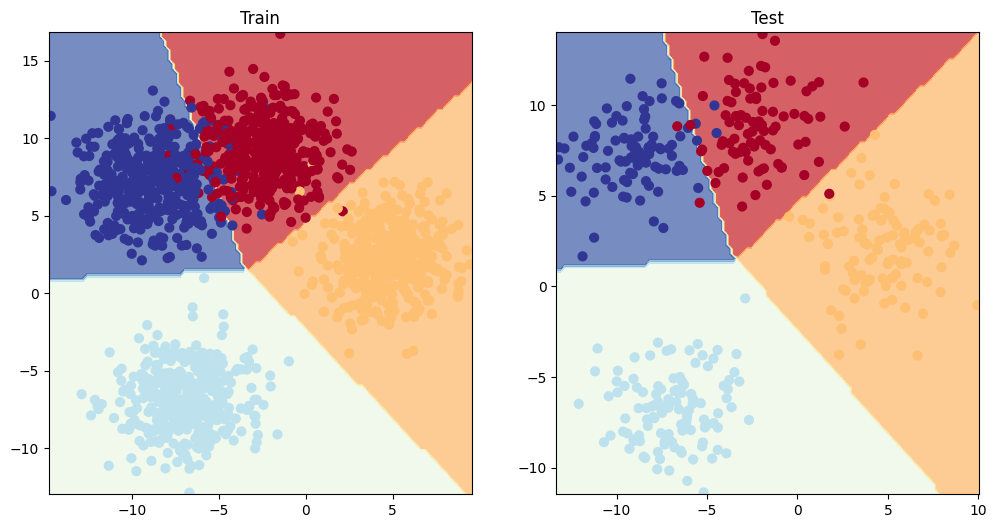

In [12]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [13]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "BlobClassificationModelV0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_3.state_dict(), f=MODEL_SAVE_PATH)

## Additional Classification Metrics
* Accuracy
* Precision
* Recall
* F1-score
* Classification Report
* Confusion Matrix

In [15]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [21]:
from torchmetrics import Accuracy

# Set up metric
torchmetric_acc = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_acc(test_preds, y_test)

tensor(0.9800, device='cuda:0')